In [1]:
import numpy as np
import cv2
from PIL import Image
from tqdm.notebook import tqdm

In [2]:
def get_mask(image):
    mask = np.array(image).sum(axis=2)
    mask[mask > 0] = 255
    return 255 - mask.astype('uint8')

def zoom(image, factor=0.05, direction='in', fill_blanks=False):
    if direction == 'in':
        mask_width = int(factor * image.width / 2)
        mask_height = int(factor * image.height / 2)
        if mask_width == 0 and mask_height == 0:
            return image
        resized_image = image.resize((image.height - 2 * mask_height, image.width - 2 * mask_width))
        blank = np.zeros_like(image)
        blank[mask_width:-mask_width, mask_width:-mask_width] = resized_image
        resized_image = Image.fromarray(blank)
        
    elif direction == 'out':
        original_width, original_height = image.size
        new_width = int(original_width * (1 + factor))
        new_height = int(original_height * (1 + factor))
        
        resized_image = image.resize((new_width, new_height), Image.LANCZOS)
        
        left = (new_width - original_width) / 2
        top = (new_height - original_height) / 2
        right = left + original_width
        bottom = top + original_height
        resized_image = resized_image.crop((left, top, right, bottom))
        
    if fill_blanks:
        resized_image = inpaint(resized_image)
    return resized_image.convert('RGB')
    
def rotate(image, factor=0.001, direction='pos', fill_blanks=False):
    angle = 360 * factor
    if direction == 'neg':
        angle = -angle
    rotated_image = image.rotate(angle, expand=False)
    if fill_blanks:
        rotated_image = inpaint(rotated_image)
    return rotated_image.convert('RGB')

def move(image, factor, direction, fill_blanks=False):
    temp = np.array(image)
    if direction == 'up':
        width = int(factor * image.height)
        temp = np.pad(temp, ((width, 0), (0, 0), (0, 0)))
        temp = temp[:image.height]
    elif direction == 'down':
        width = int(factor * image.height)
        temp = np.pad(temp, ((0, width), (0, 0), (0, 0)))
        temp = temp[-image.height:]
    elif direction == 'left':
        width = int(factor * image.width)
        temp = np.pad(temp, ((0, 0), (width, 0), (0, 0)))
        temp = temp[:, :image.width]
    elif direction == 'right':
        width = int(factor * image.width)
        temp = np.pad(temp, ((0, 0), (0, width), (0, 0)))
        temp = temp[:, -image.width:]

    res = Image.fromarray(temp)
    if fill_blanks:
        res = inpaint(res)
    return res.convert('RGB')

def inpaint(image):
    mask = get_mask(image)
    img = np.array(image)
    img = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)
    return Image.fromarray(img)

In [3]:
import torch
from compel import Compel
from diffusers import AutoPipelineForImage2Image, AutoPipelineForText2Image
from diffusers.utils import make_image_grid, load_image, export_to_video

i2i_pipe = AutoPipelineForImage2Image.from_pretrained(
    "SimianLuo/LCM_Dreamshaper_v7",
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

t2i_pipe = AutoPipelineForText2Image.from_pretrained(
    "SimianLuo/LCM_Dreamshaper_v7",
    vae=i2i_pipe.vae,
    tokenizer=i2i_pipe.tokenizer,
    text_encoder=i2i_pipe.text_encoder,
    unet=i2i_pipe.unet,
    scheduler=i2i_pipe.scheduler,
    torch_dtype=torch.float16,
    safety_checker=None
).to('cuda')

compel = Compel(tokenizer=i2i_pipe.tokenizer, text_encoder=i2i_pipe.text_encoder)


i2i_pipe.enable_xformers_memory_efficient_attention()
i2i_pipe.set_progress_bar_config(disable=True)
t2i_pipe.enable_xformers_memory_efficient_attention()
t2i_pipe.set_progress_bar_config(disable=True)

/home/soroush/.venv/lib/python3.11/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/soroush/.venv/lib/python3.11/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
/home/soroush/.venv/lib/python3.11/site-packages/diffusers/models/vq_model.py:20: FutureWarning: `VQEncoderOutput` is deprecated and will be removed in version 0.31. Importing `VQEncoderOutput` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoder

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.latent_consistency_models.pipeline_latent_consistency_img2img.LatentConsistencyModelImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.latent_consistency_models.pipeline_latent_consistency_text2img.LatentConsistencyModelPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [19]:
segments = [
    {'start': 0.0, 'end': 41.056, 'duration': 41.056},
    {'start': 41.056, 'end': 68.352, 'duration': 27.296},
    {'start': 68.352, 'end': 102.176, 'duration': 33.824},
    {'start': 102.176, 'end': 153.472, 'duration': 51.296},
    {'start': 153.472, 'end': 174.176, 'duration': 20.704},
    {'start': 174.176, 'end': 181.632, 'duration': 7.456},
    {'start': 181.632, 'end': 225.152, 'duration': 43.52},
    {'start': 225.152, 'end': 356.101, 'duration': 130.949}
]



base_prompts = [
    "A bustling city street at dawn, with the first rays of sunlight reflecting off tall glass buildings.",
    "The city slowly wakes up as early morning commuters start to fill the streets, and shop signs begin to light up.",
    "Traffic increases, and the sound of honking cars and footsteps fills the air as the city becomes more alive.",
    "As the day progresses, the streets are filled with people, and the city hums with activity under the midday sun.",
    "A bustling marketplace opens, with vendors setting up stalls and people browsing through various goods.",
    "The afternoon brings a slight lull, with some people taking breaks in nearby parks, and the shadows grow longer.",
    "Clouds gather above the city, casting a grayish hue over the buildings, as the wind starts to pick up.",
    "A light drizzle begins, with people pulling out umbrellas and car headlights reflecting off the wet pavement.",
    "The rain intensifies, and the city streets become a sea of colorful umbrellas and glistening wet surfaces.",
    "As the evening approaches, the rain stops, and the city is bathed in a soft golden light, with lights starting to twinkle in windows and on street signs."
]



negative_prompt = 'blurry, fuzzy, low quality, unstable, poor details, dark, gloomy'
generator = torch.Generator("cuda").manual_seed(7)


base_prompts = list(
    map(
        lambda x: 'A realistic photo of ' + x + ' high quality, high details, 4k',
        base_prompts
    )
)

In [17]:
import librosa
import matplotlib.pyplot as plt


# music_path = 'assets/Folly Audio/Meditation Music_moderatearousal.mp3'
music_path = 'assets/Radiohead - Everything in Its Right Place (Sam Goku Edit).mp3'
audio, sr = librosa.load(music_path)

# fps = 2
# wav_harmonic, wav_percussive = librosa.effects.hpss(audio, margin=(1.0, 5.0))
# spec_raw = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=512, hop_length=sr//fps)
# spec_max = np.amax(spec_raw, axis=0)
# spec_norm = (spec_max - np.min(spec_max)) / np.ptp(spec_max)
# # amplitude_arr = np.resize(spec_norm, int(duration * fps))
# print(spec_norm.shape)
# plt.plot(spec_norm)

In [20]:
import random


fps = 5
rotate_directions = []
zoom_directions = []
move_directions = []
for seg in segments:
    n = int(np.round(fps * seg['duration']))
    rotate_directions += [random.choice(['pos', 'neg'])] * n
    zoom_directions += [random.choice(['in', 'out'])] * n
    move_directions += [random.choice(['up', 'down', 'left', 'right'])] * n

prompts = []
n = len(move_directions) // len(base_prompts)
for p in base_prompts:
    prompts += [p] * n
prompts += [prompts[-1]] * (len(move_directions) - len(prompts))

zoom_factors = [0.005] * len(move_directions)
rotate_factors = [0.001] * len(move_directions)
move_factors = [0.005] * len(move_directions)

# zoom_factors = 0.0035 + spec_norm / 100
# rotate_factors = 0.00025 + spec_norm / 200
# move_factors = 0.0035 + spec_norm / 100


len(rotate_directions), len(zoom_directions), len(move_directions), len(prompts)

(1780, 1780, 1780, 1780)

(512, 512)


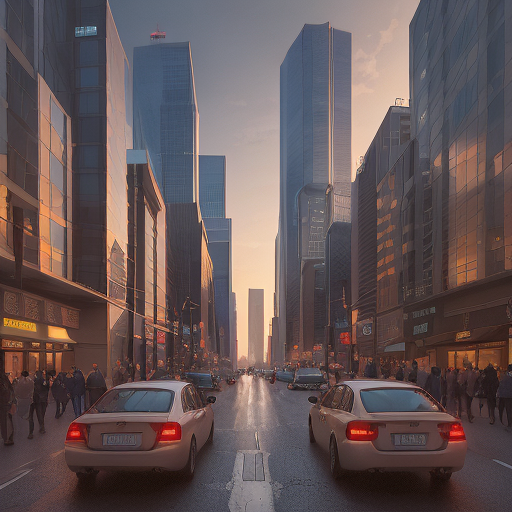

In [23]:
torch.cuda.empty_cache()

init_image = t2i_pipe(
    prompt=prompts[0],
    negative_prompt=negative_prompt,
    num_inference_steps=10,
    guidance_scale=10.,
    generator=generator,
    width=512,
    height=512
).images[0]
print(init_image.size)
init_image

In [24]:
def generate_frames(
    init_frame, 
    prompts, 
    zoom_factors, 
    zoom_directions, 
    move_factors,
    move_directions,
    rotate_factors,
    rotate_directions,
    n=None
):
    torch.cuda.empty_cache()
    
    frames = [init_frame]
    if n is None:
        n = len(prompts)
    for i in tqdm(range(n)):
        image = frames[-1]
        image = zoom(
            image, 
            factor=zoom_factors[i], 
            direction=zoom_directions[i], 
            fill_blanks=True
        )
        image = move(
            image, 
            factor=move_factors[i], 
            direction=move_directions[i], 
            fill_blanks=True
        )
        image = rotate(
            image, 
            factor=rotate_factors[i], 
            direction=rotate_directions[i], 
            fill_blanks=True
        )

        new_prompt = (i > 0) and (prompts[i] != prompts[i-1])
        frames += i2i_pipe(
            prompt=prompts[i],
            negative_prompt=negative_prompt + ', night',
            image=image,
            num_inference_steps=4,
            guidance_scale=8. if new_prompt else 2.,
            strength=0.6 if new_prompt else 0.4,
            generator=generator
        ).images
    return frames

def encode_image(image):
    x = t2i_pipe.image_processor.preprocess(image).to(torch.float16).to(t2i_pipe.device)
    return t2i_pipe.vae.encode(x).latent_dist.sample().cpu().detach()[0]

def decode_image(z):
    image = t2i_pipe.vae.decode(
        z.unsqueeze(0).to(t2i_pipe.device), 
        return_dict=False
    )[0].cpu().detach()
    return t2i_pipe.image_processor.postprocess(image, output_type='pil', do_denormalize=[True])[0]

def interpolate_latents(image1, image2, steps=1):
    T = torch.linspace(0.0, 1.0, 2 + steps).to(torch.float16)[1:-1]
    x = encode_image(image1)
    y = encode_image(image2)
    res = []
    for t in T:
        z = torch.lerp(x, y, t)
        res += [decode_image(z)]
    return res

def upsample(frames, scale=1):
    res = []
    for i, f in enumerate(tqdm(frames[:-1])):
        res += [f]
        res += interpolate_latents(f, frames[i+1], scale - 1)
    res += [frames[-1]]
    return res

In [28]:
frames = generate_frames(
    init_image, 
    prompts, 
    zoom_factors, 
    zoom_directions, 
    move_factors,
    move_directions,
    rotate_factors,
    rotate_directions,
    # n=300
)

  0%|          | 0/1780 [00:00<?, ?it/s]

In [38]:
# make_image_grid(frames[0:3600:0], rows=4, cols=5)

In [29]:
up_frames = upsample(frames, scale=4)
len(up_frames) / len(frames)

  0%|          | 0/1780 [00:00<?, ?it/s]

3.9983155530600785

In [30]:
fps = 20
idx = int(len(up_frames) / fps * sr) + 1
x = torch.tensor(audio[:idx]).unsqueeze(0)
x.shape[1] / sr

356.05002267573695

In [32]:
from torchvision.io import write_video
from torchvision.transforms.functional import pil_to_tensor

up_frames = [pil_to_tensor(frame) for frame in up_frames]
up_frames = torch.stack(up_frames).permute(0, 2, 3, 1)

write_video(
    'radiohead-fps5->20.mp4',
    up_frames,
    fps=10,
    audio_array=x,
    audio_fps=sr,
    audio_codec="aac",
    options={"crf": "10", "pix_fmt": "yuv420p"},
)